PLAN:

The goal is to make plots of both the integrals and the geonu detectable counts (from U, Th and total) by taking the survival probability into account in different ways:

1) Use constant $P_{ee}$ from Ingrida's thesis
2) Use approximate formula for $P_{ee}$ but don't take it out of the integral; use latest values of $\theta_{12}$ and all those
3) Use approximate formula for $P_{ee}$ and don't take it out of the integral; use a few different values of the 1-2 oscillation parameters but keep the 1-3 oscillation parameters as constants

Based on some plots I saw in the collaboration meeting (I think from Tony, but also maybe from James), I think that when you use the correct scaling factors, we end up expecting like 1-2 geonus in each bin in the range that seems to actually be affected by changing how the survival probability is taken into account (not in the big peak at the start, but in the "softer" peak). We shall see

I will use the simple Earth model (constant density and abundance in core+mantle)


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [77]:
#make earth grid
#use very low grid count for now because it takes ages to run; tried with 250 and it didn't have enough memory for huge array


grid_count = 250
coordinates = np.linspace(-6371, 6371, grid_count)
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

earth_grid = np.zeros((grid_count**3, 3))
index = 0

for i in range(grid_count):
    for j in range(grid_count):
        for k in range(grid_count):
            if x_coordinates[i, j, k]**2 + y_coordinates[i, j, k]**2 + z_coordinates[i, j, k]**2 <= 6371**2:
                earth_grid[index] = np.array([x_coordinates[i, j, k], y_coordinates[i, j, k], z_coordinates[i, j, k]])
                index += 1

earth_grid = earth_grid[:index]

In [78]:
#separate mantle from core

core_radius = 3486
mantle_crust_mask = (earth_grid[:, 0]**2 + earth_grid[:, 1]**2 + earth_grid[:, 2]**2 >= core_radius**2)

mantle_crust_grid = earth_grid[mantle_crust_mask]
core_grid = earth_grid[~mantle_crust_mask]

# Reshape the arrays to have three columns
mantle_crust_grid = mantle_crust_grid.reshape(-1, 3)
core_grid = core_grid.reshape(-1, 3)

In [79]:
#set abundances and densities; weight average density by shell volume

rho_core = 0
A_Th_core = 0
A_U_core = 0

rho_mantle = 4.5 #g/cm^3 -- I just looked this up
#I'm not sure what the units are supposed to be but this will just be a scaling factor, we mostly care about the shape of 
#the spectrum, not the absolute value 

A_Th_c = 5 * (10**(-6))
A_Th_m = 8 * (10**(-8))
A_U_c = 1 * (10**(-6))
A_U_m = 2 * (10**(-8))

r_outer_crust = 6371
r_inner_crust = 6371 - 20
r_outer_mantle = r_inner_crust
r_inner_mantle = r_outer_mantle - 2900

def shell_volume(r_inner, r_outer):
    return (4/3)*math.pi*(r_outer**2 + r_outer*r_inner + r_inner**2)*(r_outer - r_inner)

crust_volume = shell_volume(r_inner_crust, r_outer_crust)
mantle_volume = shell_volume(r_inner_mantle, r_outer_mantle)

print("Crust volume is "+str(crust_volume))
print("Mantle volume is "+str(mantle_volume))

A_Th_mantle = (A_Th_m*mantle_volume + A_Th_c*crust_volume)/(crust_volume + mantle_volume)
A_U_mantle = (A_U_m*mantle_volume + A_U_c*crust_volume)/(crust_volume + mantle_volume)

Crust volume is 10169298809.643768
Mantle volume is 900881093278.6835


In [80]:
#set position of SNO+

SNO_r = np.array([0, 0, 6369])

In [81]:
# function to calculate relative distance to SNO+ from points in earth grid

def calc_relative_dist(points_array):
    relative_distances = np.zeros(len(points_array))
    for i in range(len(points_array)):
        # Index each point individually
        point = points_array[i]
        relative_distances[i] = np.sqrt((point[0] - SNO_r[0])**2 + (point[1] - SNO_r[1])**2 + (point[2] - SNO_r[2])**2)

    return relative_distances
#distances calculated in km

In [82]:
#make abundances and density into arrays; not super useful now but might be easier if you have different regions

A_Th_array = np.full(len(mantle_crust_grid), A_Th_mantle)
A_U_array = np.full(len(mantle_crust_grid), A_U_mantle)

rho_array = np.full(len(mantle_crust_grid), rho_mantle*1000) # x1000 to convert from g/cm^3 to kg/m^3

In [83]:
#define Delta function for an array of points and energies
#inputs: appropriate deltam _ij^2, energy array [MeV], points array
#relative distance calculated in km, hence Delta scaled up by a factor of 1000 to account for m-km conversion


def Delta_ij(energy_array, points_array, delta_m_ij_squared):
    
    Delta = np.zeros((len(energy_array), len(points_array)))
    #want positions relative to sno+
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            Delta[i][j] = (1.27 * delta_m_ij_squared * relative_distance_array[j] * 1000) / (energy_array[i])
            
    return Delta

In [84]:
#define simplified survival probability for arrays of points and energies

def P_ee_simplified(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    #want positions relative to sno+
    relative_distance_array = calc_relative_dist(points_array)
    
        
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - ( (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2 * (np.sin(Delta_12[i][j]))**2 + (1/2) * (np.sin(2 * theta_13))**2)
            
    return P_ee

In [85]:
#set standard oscillation parameters

theta_12 = 0.5903 #rad
theta_23 = 0.8430 #rad
theta_13 = 0.1503 #rad

delta_m_21_squared = 7.39 * 10**(-5) #eV^2
delta_m_32_squared = 2.449 * 10**(-3) #eV^2
delta_m_31_squared = delta_m_32_squared

In [86]:
energy_array = np.linspace(1.8, 3.3, 100)

In [87]:
#define Thorium integral using approximate formula in terms of points and energies

def integral_over_positions_Th(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_simplified(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_Th_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            #print("computed for energy "+str(j)+" out of "+str(len(energy_array)))
            
    return sum

In [88]:
#define Uranium integral using approximate formula in terms of points and energies

def integral_over_positions_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_simplified(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_U_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum #this is an array of length = len(energy_array)
    #can identify integral for each energy by index

In [89]:
#integral naming schemes

#Th_integral_values for approximate formula, standard oscillation parameters
#Th_integral_values_low_theta for some lower theta, approximate formula; same for mid and high
#Th_integral_values_constant_P_ee for integrating using constant survival probability

In [90]:
coordinates = np.linspace(-6371, 6371, grid_count)
grid_1d_size = coordinates[1] - coordinates[0]
print(grid_1d_size)

51.17269076305183


In [91]:
#Compute Th integral using approximate P_ee formula and standard oscillation parameters
Th_integral_values = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array)

In [92]:
#Compute U integral using approximate P_ee formula and standard oscillation parameters
U_integral_values = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array)

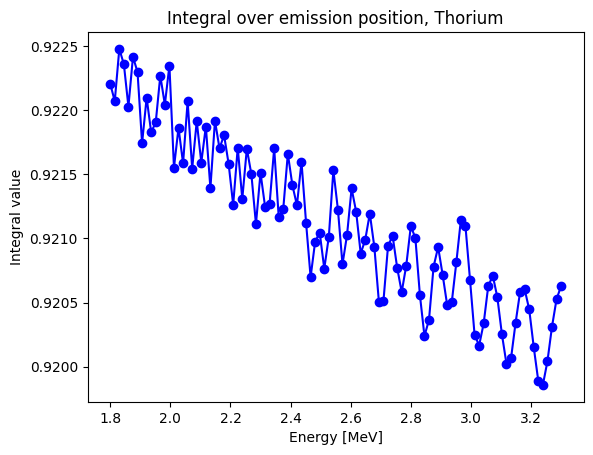

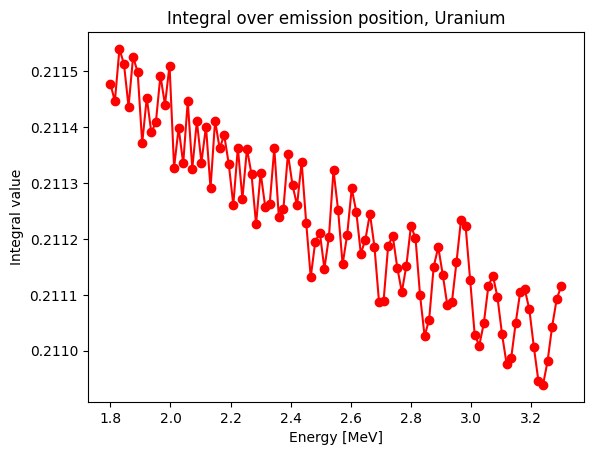

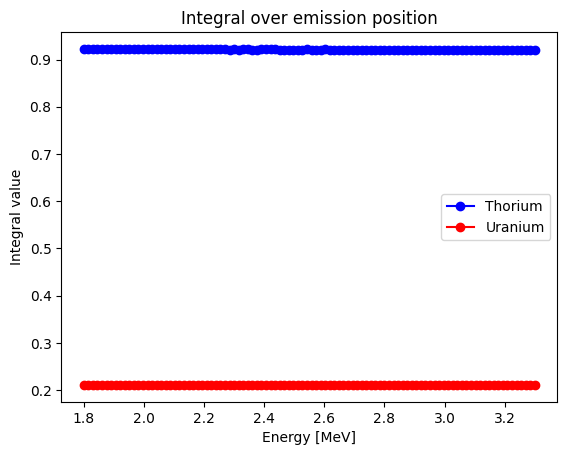

In [93]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
plt.show()

It looks like it really matters how fine the earth grid is; rerun with size 100

In [94]:
#define Thorium integral using constant P_ee value
def integral_over_positions_Th_constant_P_ee(points_array, energy_array, A_Th_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    
    #value from Ingrida's thesis, probably the same as in rat\n",
    P_ee = 0.553
    #we lose the energy dependence in the integral because it only shows up in P_ee, which is now taken to be constant
    #so now instead of a range of values, there is just one value; keep it as an array to make it easier to make plots
    #but all the elements in the array will be the same
    
    sum_value = 0
    
    for i in range(len(points_array)):
        sum_value += P_ee * ((A_Th_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        for j in range(len(sum)):
            sum[j] = sum_value
            
    return sum

In [95]:
#define Uranium integral using constant P_ee value
def integral_over_positions_U_constant_P_ee(points_array, energy_array, A_Th_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    
    #value from Ingrida's thesis, probably the same as in rat\n",
    P_ee = 0.553
    #we lose the energy dependence in the integral because it only shows up in P_ee, which is now taken to be constant
    #so now instead of a range of values, there is just one value; keep it as an array to make it easier to make plots
    #but all the elements in the array will be the same
    
    sum_value = 0
    
    for i in range(len(points_array)):
        sum_value += P_ee * ((A_U_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        for j in range(len(sum)):
            sum[j] = sum_value
            
    return sum

In [96]:
#Compute Th integral values using constant P_ee from Ingrida's thesis
Th_integral_values_constant_P_ee = integral_over_positions_Th_constant_P_ee(mantle_crust_grid, energy_array, A_Th_array, rho_array)

In [97]:
#Compute U integral values using constant P_ee from Ingrida's thesis
U_integral_values_constant_P_ee = integral_over_positions_U_constant_P_ee(mantle_crust_grid, energy_array, A_U_array, rho_array)

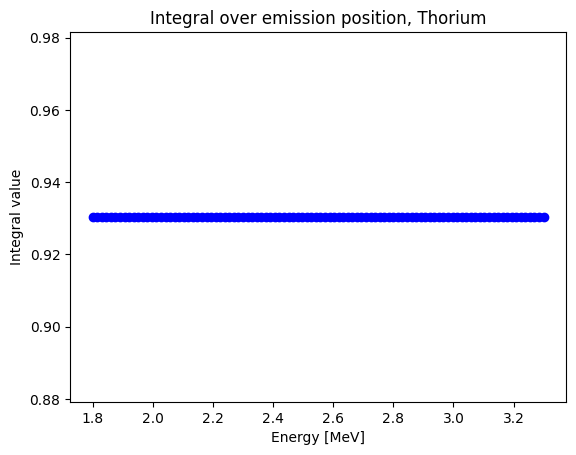

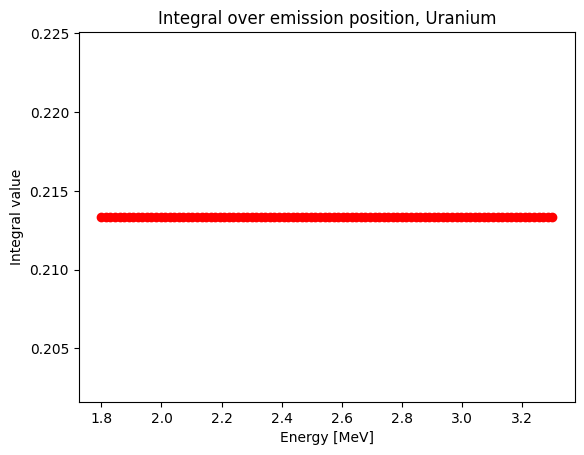

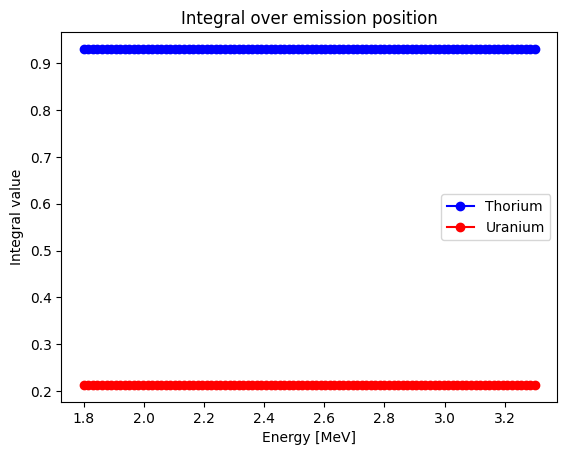

In [98]:
#make plots, just for integrals with constant P_ee

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
plt.show()

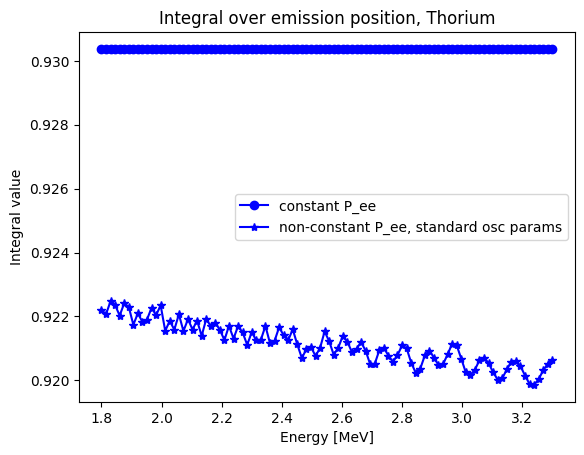

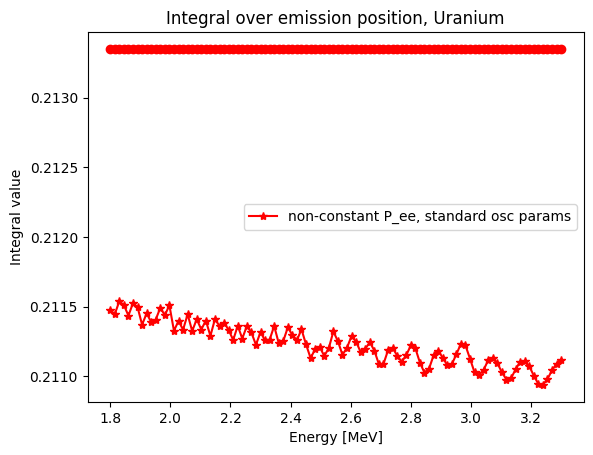

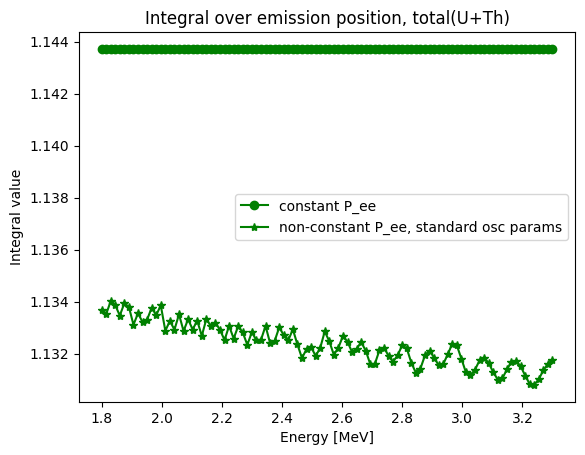

In [99]:
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
plt.show()

#Total

plt.plot(energy_array, U_integral_values_constant_P_ee + Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='g', label = 'constant P_ee')
plt.plot(energy_array, U_integral_values + Th_integral_values, marker='*', linestyle='-', color='g', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th)')
plt.legend()
plt.show()

So we can see that using the same constant as Ingrida consistently over-estimates the geonu flux; Need to run this with more earth grid bins to make sure and separate mantle/crust but yeah, ok so far;

Now want to compute the total fluxes and see how it compares

In [100]:
#change to survival probability from Shuai

def sigma_IBD(energy_array):
    
    m_e = 0.511 #MeV
    m_p = 938 #MeV
    m_n = 941 #MeV
    E_th = 1.8 #MeV
    
    sigma = np.zeros(len(energy_array))
    
    for i in range(len(energy_array)):
        sigma [i] = ((energy_array[i] - E_th + m_e)**2) * ((1 - (m_e)**2/((energy_array[i] - E_th + m_e)**2))**(1/2))
    
    return sigma

The survival probability from Shuai is this (in cm^2 but ignore scale factor in code):

$$\sigma_{IBD}(E_{\nu}) = 9.52 \times 10^{-44} (E_{\nu} - M_n + M_p)^2 \cdot (1 - \frac{m_e^2}{(E_{\nu} - M_n + M_p)^2})^{1/2}$$

In [101]:
#all these + sources in Earth model more bins -3 (for example)

lambda_U = 4.916
lambda_Th = 1.563
mu_U = 235
mu_Th = 232

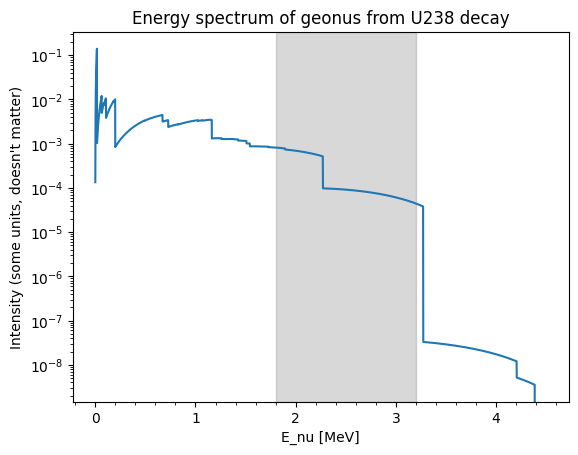

In [102]:
#get fluxes


energy_array_U = []
dn_dE_U = []

with open('U238_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_U.append(float(columns[0]))
        dn_dE_U.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_U = np.array(energy_array_U) / 1000
dn_dE_U = np.array(dn_dE_U)

plt.plot(energy_array_U, dn_dE_U)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from U238 decay')

# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.show()


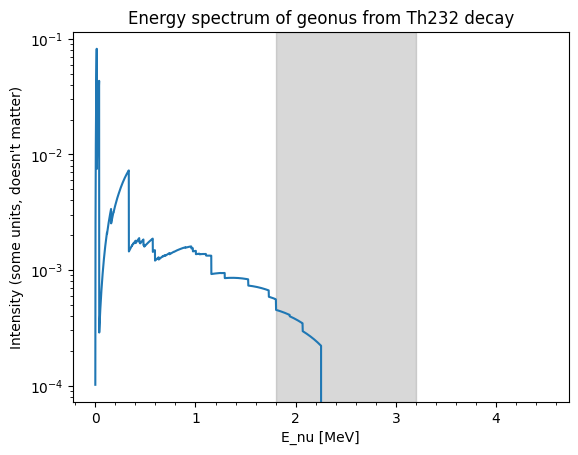

In [103]:
energy_array_Th = []
dn_dE_Th = []

with open('Th232_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_Th.append(float(columns[0]))
        dn_dE_Th.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_Th = np.array(energy_array_Th) / 1000
dn_dE_Th = np.array(dn_dE_Th)

plt.plot(energy_array_Th, dn_dE_Th)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from Th232 decay')

# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.show()

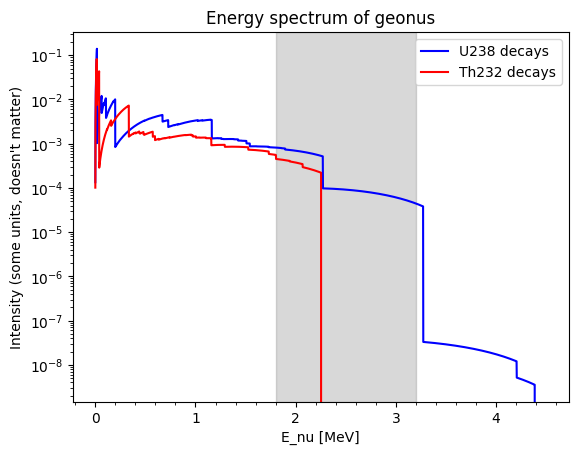

In [104]:
# Plot U238 decay data (blue line)
plt.plot(energy_array_U, dn_dE_U, label='U238 decays', color='blue')

# Plot Th232 decay data (red line)
plt.plot(energy_array_Th, dn_dE_Th, label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

In [105]:
def rebin_counts(initial_bins, counts_in_initial_bins, final_bin_midpoints):
    """
    Rebins counts data.

    Parameters:
    - initial_bins: array, bin edges of the initial data
    - counts_in_initial_bins: array, counts in each initial bin
    - final_bin_midpoints: array, midpoints of the final desired bins

    Returns:
    - counts_in_final_bins: array, counts in each final bin
    """

    # Calculate bin midpoints of the initial bins
    bin_midpoints = (initial_bins[:-1] + initial_bins[1:]) / 2

    # Use np.histogram to calculate counts in final bins
    counts_in_final_bins, _ = np.histogram(initial_bins, bins=np.concatenate([initial_bins, [2 * initial_bins[-1] - initial_bins[-2]]]), weights=counts_in_initial_bins)

    # Interpolate the counts to the final bin midpoints
    counts_in_final_bins = np.interp(final_bin_midpoints, bin_midpoints, counts_in_final_bins[:-1])

    return counts_in_final_bins

In [106]:
dn_dE_rebinned_U = rebin_counts(energy_array_U, dn_dE_U, energy_array)
dn_dE_rebinned_Th = rebin_counts(energy_array_Th, dn_dE_Th, energy_array)

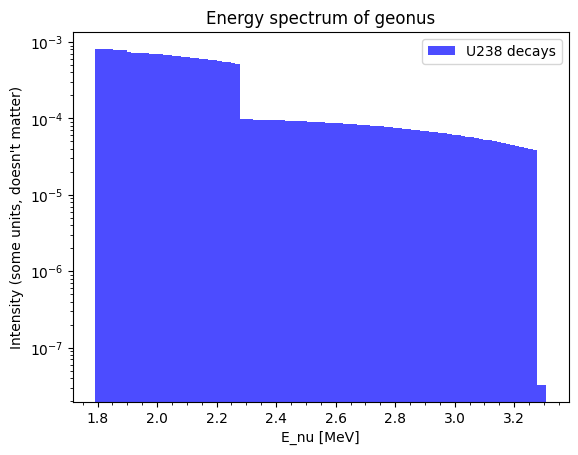

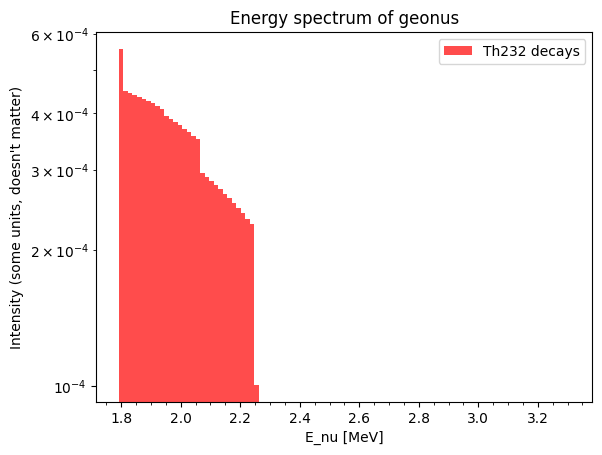

In [107]:
bin_width = energy_array[1] - energy_array[0]

# Plot histogram U
plt.bar(energy_array, dn_dE_rebinned_U, width=bin_width, label='U238 decays', color='blue', alpha=0.7)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

# Plot histogram Th
plt.bar(energy_array, dn_dE_rebinned_Th, width=bin_width, label='Th232 decays', color='red', alpha=0.7)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

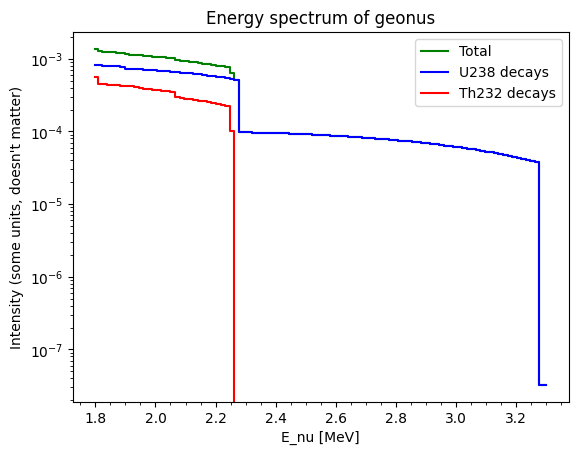

In [108]:
# Plot histogram for both
plt.step(energy_array, dn_dE_rebinned_U + dn_dE_rebinned_Th, where='mid', label='Total', color='green')
plt.step(energy_array, dn_dE_rebinned_U, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, dn_dE_rebinned_Th, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [109]:
sigma = sigma_IBD(energy_array)


In [110]:
N_Th = np.zeros(len(energy_array))
N_U = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values[i]
    N_U[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values[i]
    

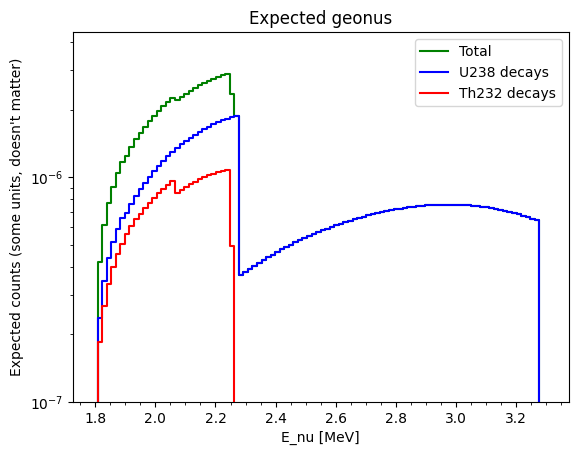

In [111]:
# Plot histogram for both
plt.step(energy_array, N_U + N_Th, where='mid', label='Total', color='green')
plt.step(energy_array, N_U, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [112]:
N_Th_constant_P_ee = np.zeros(len(energy_array))
N_U_constant_P_ee = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_constant_P_ee[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_constant_P_ee[i]
    N_U_constant_P_ee[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_constant_P_ee[i]
    

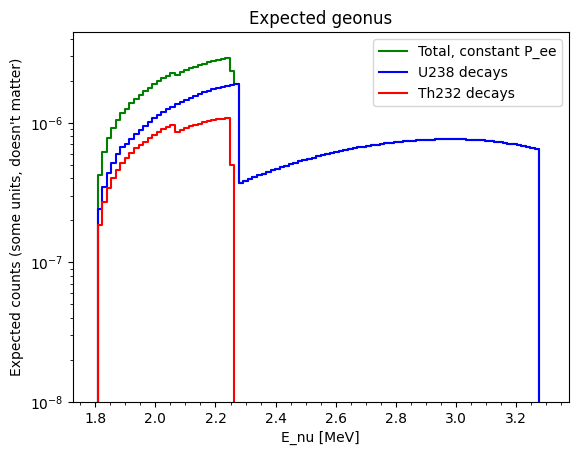

In [113]:
# Plot histogram for both, constant P_ee only
plt.step(energy_array, N_U_constant_P_ee + N_Th_constant_P_ee, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_constant_P_ee, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_constant_P_ee, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-8)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

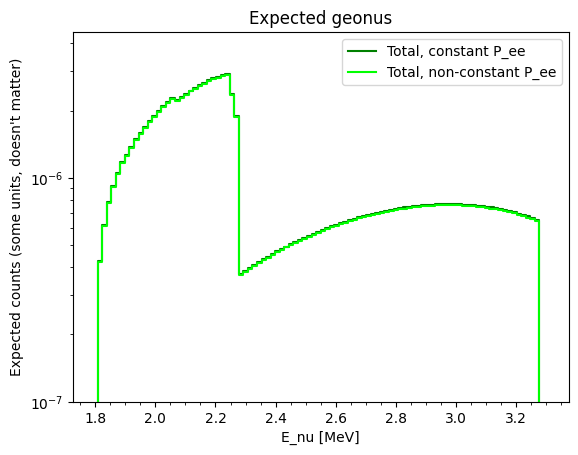

/tmp/ipykernel_24311/1210757435.py:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_constant_P_ee + N_Th_constant_P_ee) / (N_U + N_Th), label='ratio', color='green')


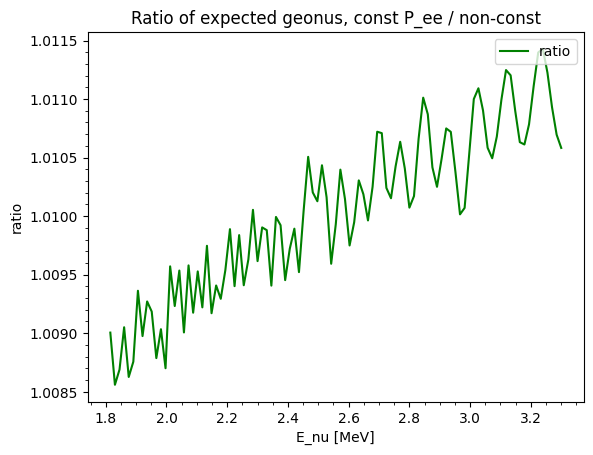

In [114]:
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_constant_P_ee + N_Th_constant_P_ee, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='Total, non-constant P_ee', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee + N_Th_constant_P_ee) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

Now compute for different values of theta_12 and delta_m_21_squared

In [115]:
theta_12_low = 0.2 #rad
theta_12_high = 1

delta_m_21_squared_low = 5 * 10**(-5) #eV^2
delta_m_21_squared_high = 1.2 * 10**(-4)

In [116]:
#vary theta first

#Compute Th integral using approximate P_ee formula and low theta
Th_integral_values_theta_low = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low, delta_m_21_squared, A_Th_array, rho_array)

In [117]:
#Compute Th integral using approximate P_ee formula and high theta
Th_integral_values_theta_high = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high, delta_m_21_squared, A_Th_array, rho_array)

In [118]:
#Compute U integral using approximate P_ee formula and low theta
U_integral_values_theta_low = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low, delta_m_21_squared, A_U_array, rho_array)

In [119]:
#Compute Th integral using approximate P_ee formula and low theta
U_integral_values_theta_high = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high, delta_m_21_squared, A_U_array, rho_array)

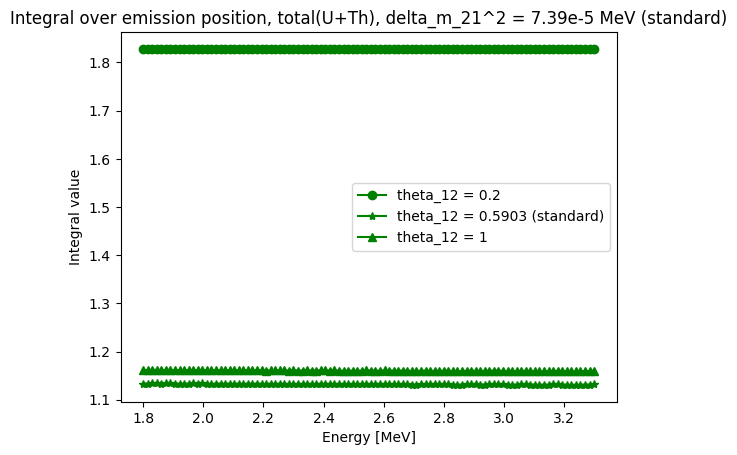

In [120]:
#make plots of integral to compare

#Total

plt.plot(energy_array, U_integral_values_theta_low + Th_integral_values_theta_low, marker='o', linestyle='-', color='g', label = 'theta_12 = 0.2')
plt.plot(energy_array, U_integral_values + Th_integral_values, marker='*', linestyle='-', color='g', label = 'theta_12 = 0.5903 (standard)')
plt.plot(energy_array, U_integral_values_theta_high + Th_integral_values_theta_high, marker='^', linestyle='-', color='g', label = 'theta_12 = 1')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th), delta_m_21^2 = 7.39e-5 MeV (standard)')
plt.legend()
plt.show()

In [121]:
#calculate total expected fluxes

N_Th_theta_low = np.zeros(len(energy_array))
N_U_theta_low = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_theta_low[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_theta_low[i]
    N_U_theta_low[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_theta_low[i]
    

In [122]:

N_Th_theta_high = np.zeros(len(energy_array))
N_U_theta_high = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_theta_high[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_theta_high[i]
    N_U_theta_high[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_theta_high[i]
   

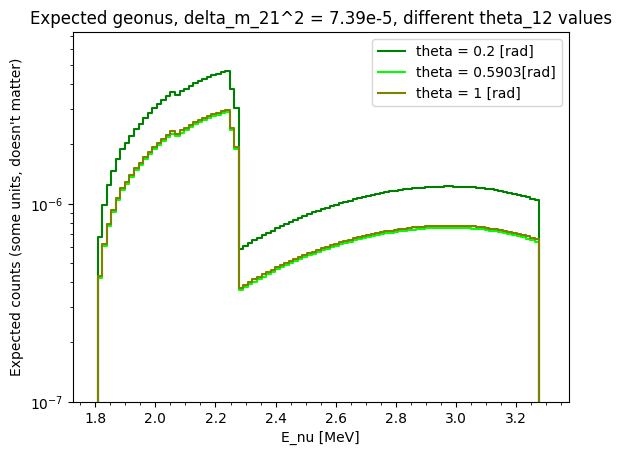

/tmp/ipykernel_24311/3327028500.py:27: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_theta_low + N_Th_theta_low) / (N_U + N_Th), label='ratio', color='green')


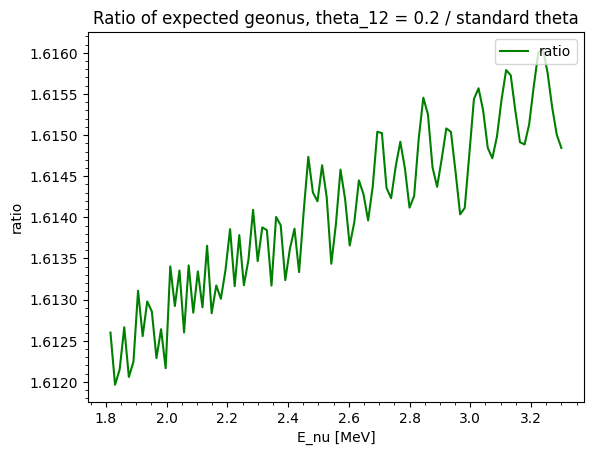

/tmp/ipykernel_24311/3327028500.py:43: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_theta_high + N_Th_theta_high) / (N_U + N_Th), label='ratio', color='olive')


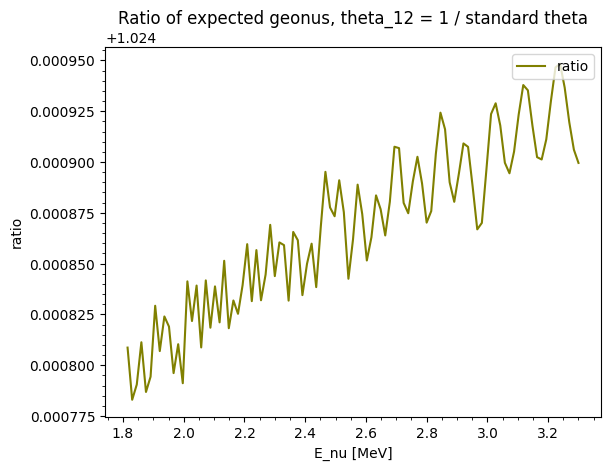

In [123]:
#plot comparisons

#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_theta_low + N_Th_theta_low, where='mid', label='theta = 0.2 [rad]', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='theta = 0.5903[rad]', color='lime')
plt.step(energy_array, N_U_theta_high + N_Th_theta_high, where='mid', label='theta = 1 [rad]', color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, delta_m_21^2 = 7.39e-5, different theta_12 values')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


plt.plot(energy_array, (N_U_theta_low + N_Th_theta_low) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, theta_12 = 0.2 / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

plt.plot(energy_array, (N_U_theta_high + N_Th_theta_high) / (N_U + N_Th), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, theta_12 = 1 / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

I'm not sure that the things above should have the same shape... it seems a bit sus

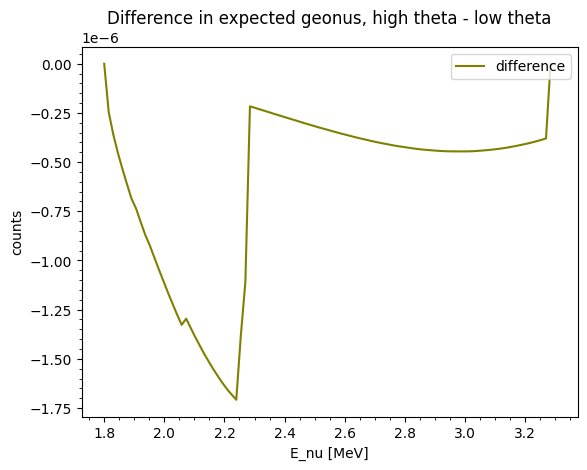

In [124]:
plt.plot(energy_array, N_U_theta_high + N_Th_theta_high - N_U_theta_low - N_Th_theta_low, label='difference', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('counts')
plt.title('Difference in expected geonus, high theta - low theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

This looks a bit better I guess but I still don't fully get it. Anyway, do the same thing but use the normal theta_12 and different delta_m_21^2

In [125]:
#Compute Th integral using approximate P_ee formula and low delta_m_21_squared
Th_integral_values_delta_m_low = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_low, A_Th_array, rho_array)

In [126]:
#Compute Th integral using approximate P_ee formula and high delta_m_21_squared
Th_integral_values_delta_m_high = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_high, A_Th_array, rho_array)

In [127]:
#Compute U integral using approximate P_ee formula and low delta_m_21_squared
U_integral_values_delta_m_low = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_low, A_U_array, rho_array)

In [128]:
#Compute U integral using approximate P_ee formula and high delta_m_21_squared
U_integral_values_delta_m_high = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_high, A_U_array, rho_array)

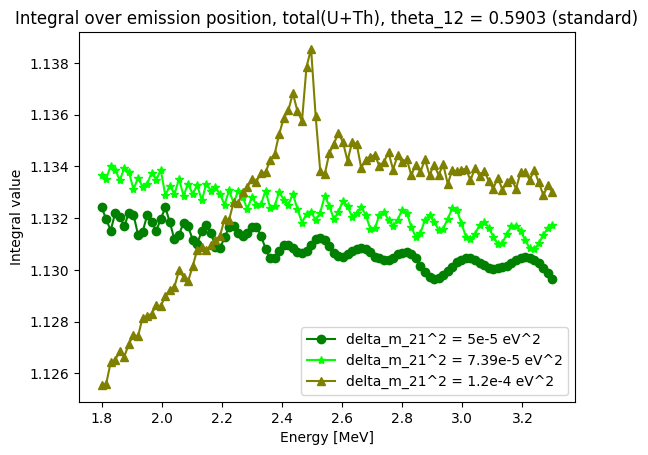

In [129]:
#make plots of integral to compare

#Total

plt.plot(energy_array, U_integral_values_delta_m_low + Th_integral_values_delta_m_low, marker='o', linestyle='-', color='g', label = 'delta_m_21^2 = 5e-5 eV^2')
plt.plot(energy_array, U_integral_values + Th_integral_values, marker='*', linestyle='-', color='lime', label = 'delta_m_21^2 = 7.39e-5 eV^2')
plt.plot(energy_array, U_integral_values_delta_m_high + Th_integral_values_delta_m_high, marker='^', linestyle='-', color='olive', label = 'delta_m_21^2 = 1.2e-4 eV^2')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th), theta_12 = 0.5903 (standard)')
plt.legend()
plt.show()

In [130]:
#calculate total expected fluxes

N_Th_delta_m_low = np.zeros(len(energy_array))
N_U_delta_m_low = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_delta_m_low[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_delta_m_low[i]
    N_U_delta_m_low[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_delta_m_low[i]
    

In [131]:
N_Th_delta_m_high = np.zeros(len(energy_array))
N_U_delta_m_high = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_delta_m_high[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_delta_m_high[i]
    N_U_delta_m_high[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_delta_m_high[i]
    

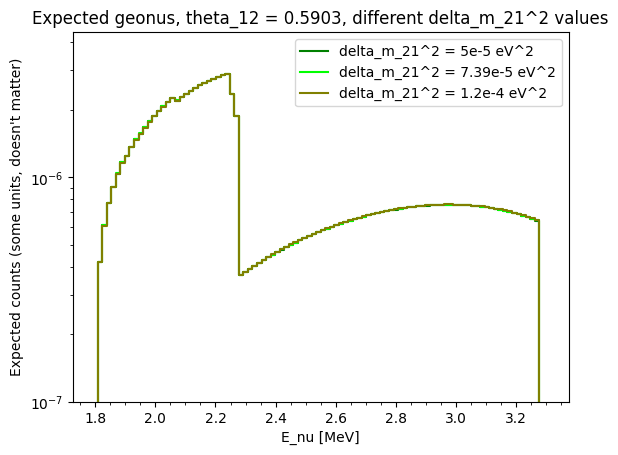

/tmp/ipykernel_24311/1662380165.py:24: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_delta_m_low + N_Th_delta_m_low) / (N_U + N_Th), label='ratio', color='green')


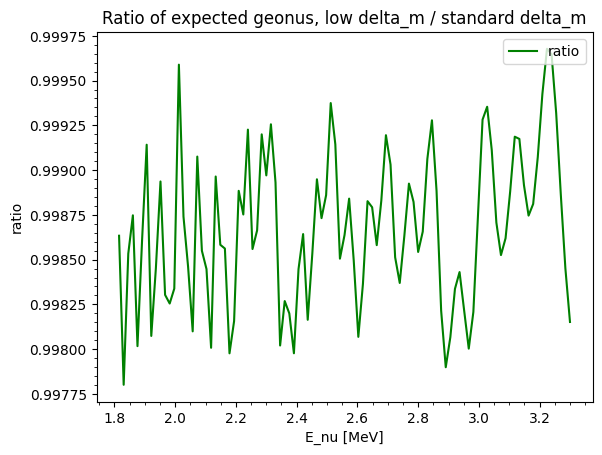

/tmp/ipykernel_24311/1662380165.py:40: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_delta_m_high + N_Th_delta_m_high) / (N_U + N_Th), label='ratio', color='olive')


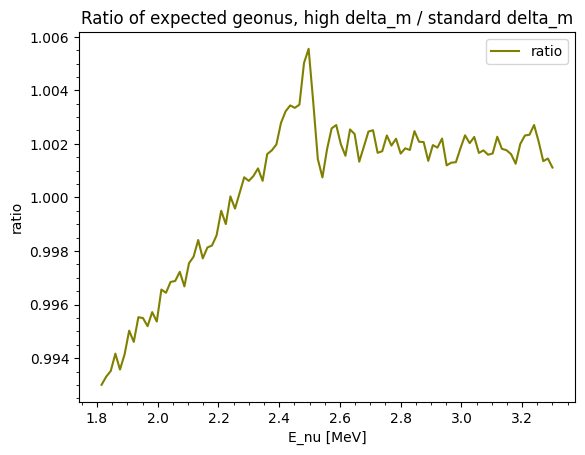

In [132]:
#plot comparisons
plt.step(energy_array, N_U_delta_m_low + N_Th_delta_m_low, where='mid', label='delta_m_21^2 = 5e-5 eV^2', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='delta_m_21^2 = 7.39e-5 eV^2', color='lime')
plt.step(energy_array, N_U_delta_m_high + N_Th_delta_m_high, where='mid', label='delta_m_21^2 = 1.2e-4 eV^2', color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, theta_12 = 0.5903, different delta_m_21^2 values')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


plt.plot(energy_array, (N_U_delta_m_low + N_Th_delta_m_low) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low delta_m / standard delta_m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

plt.plot(energy_array, (N_U_delta_m_high + N_Th_delta_m_high) / (N_U + N_Th), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high delta_m / standard delta_m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()